In [7]:
import torch

d = torch.load("res/dp2_random_dynamic_0.01_insertNode_same_neighborinsert_True_0.2_random_None.pt")

In [41]:
d.keys()

dict_keys(['statistic', 'target_nodes', 'node_pairs', 'num_direct_connections', 'attack_time', 'attack_params', 'attack_type', 'node_pair_num', 'origin_output', 'auc'])

In [2]:
d["attack_params"]

Namespace(mode='attack', seed=42, n_epoch=500, dataset='lastfm', model_path='./revision_old/outputs/trained_model/gcn/lastfm/nlayer_4_hdim_128_lr_0.1_epoch_300_None.pt', model='gcn', attack_type='inf_3', attack_node_num=50, attack_low_degree=6, attack_high_degree=10, insert_node_feature='random', attack_node_degree='', dynamic=False, insert_node_strategy='same', perturb_rate=0.1, dynamic_insert_neighbor=False, n_neighborhood_new_node=0.2, dp2_insert_node='target', root_path='revision_old', num_node_pairs=10, sample_node_subpath='/', dynamic_rate=0.01, evolving_mode='all', lr=0.01, dropout=0.5, num_epoch=300, num_layers=4, h_dim=128, remove_self_loop=True, patience=10, momentum=0.9, weight_decay=0.0005, batch_size=32, lr_scheduler='ReduceLROnPlateau', gpuid=['7'], num_of_worker=32, result_path=None, threshold_ratio=1, by_degree=False, degree_low=5, degree_high=10, is_balanced=False, against_defense=False, noise_seed=42, defense_type='', dp_epsilon=0.1, dp_delta=1e-05, clipping_param=3, 

In [8]:
cur = 1
sta = d["statistic"][cur]
dc = d["num_direct_connections"][cur]

print(f"connected {dc}")
# Compute element-wise division
result = [x / y for x, y in sta]

# Print result
for i, j in enumerate(result):
    print(f"{i} : {j}")


connected 4


In [9]:
sta


{}

In [ ]:
import numpy as np
import random


def evaluate_attack(scores, positive_fraction=0.1, num_trials=100):
    """
    Evaluate the attack by sampling a threshold from known positive scores.
    
    Args:
    - scores: List of predicted scores (higher is more likely positive).
    - positive_fraction: Fraction of top scores considered positive.
    - num_trials: Number of trials for random threshold selection.
    
    Returns:
    - Dictionary of averaged F1, precision, recall across trials.
    """

    # Sort scores in descending order to determine ground truth
    scores = np.array(scores)
    sorted_indices = np.argsort(scores)[::-1]  # Sort indices descending
    n = int(len(scores) * positive_fraction)  # Number of actual positives
    
    # Generate ground-truth labels (top `n` are positive)
    ground_truth = np.zeros(len(scores), dtype=int)
    ground_truth[sorted_indices[:n]] = 1  # Mark top `n` scores as positive
    
    # Store results
    all_f1, all_precision, all_recall = [], [], []

    for _ in range(num_trials):
        # Sample a threshold from the top `n` scores
        sampled_threshold = random.choice(scores[sorted_indices[:n]])

        # Generate predictions using this threshold
        predictions = (scores >= sampled_threshold).astype(int)

        # Compute metrics
        precision = precision_score(ground_truth, predictions, zero_division=0)
        recall = recall_score(ground_truth, predictions, zero_division=0)
        f1 = f1_score(ground_truth, predictions, zero_division=0)

        # Store results
        all_f1.append(f1)
        all_precision.append(precision)
        all_recall.append(recall)

    # Compute average results
    return {
        "F1-score": np.mean(all_f1),
        "Precision": np.mean(all_precision),
        "Recall": np.mean(all_recall)
    }

# Example usage
np.random.seed(42)
random.seed(42)
scores = np.random.rand(1000)  # Random scores between 0 and 1
result = evaluate_attack(scores, positive_fraction=0.1, num_trials=100)

print("Averaged Metrics Across Trials:")
print(result)


In [6]:
d["statistic"][2][15]

(1.6660004575896892e-07, 0.0)

# baseline 

In [4]:
from torch_geometric.datasets import LastFMAsia

graph_dataset = LastFMAsia(root='./data/lastfm/', )[0]



In [6]:
graph_dataset

Data(x=[7624, 128], edge_index=[2, 55612], y=[7624])

In [3]:
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

2.0.0+cu118
2.6.1


result

In [7]:
import torch

from scipy.spatial.distance import cosine, euclidean, correlation, chebyshev, braycurtis, canberra, cityblock, \
    sqeuclidean

DISTANCE_METRICS_LIST = [cosine, euclidean, correlation, chebyshev, braycurtis, canberra, cityblock, sqeuclidean]
DISTANCE_METRICS_LIST_NAME = ['cosine', 'euclidean', 'correlation', 'chebyshev', 'braycurtis', 'canberra', 'cityblock',
                              'sqeuclidean']


# DISTANCE_METRICS_LIST = [cosine, euclidean, correlation]
# DISTANCE_METRICS_LIST_NAME = ['cosine', 'euclidean', 'correlation']
def evaluate_with_threshold(data_list, num_connected, threshold):
    print(data_list)
    print(num_connected)
    y_true = [1] * num_connected + [0] * (len(data_list) - num_connected)
    sorted_res = sorted(data_list, reverse=True)
    # threshold - 1 == the threshold-th largest number in the sorted list
    k_th_largest = sorted_res[threshold]
    data_list = np.array(data_list)
    y_true = np.array(y_true)
    permutation = np.random.permutation(len(data_list))
    shuffled_probs = data_list[permutation]
    shuffled_labels = y_true[permutation]
    y_pred = []
    cnt = 0
    for cur in shuffled_probs:
        if k_th_largest == 0:
            if cur > 0:
                y_pred.append(1)
                cnt += 1
            else:
                y_pred.append(0)
        elif cur > k_th_largest and cnt < threshold:
            y_pred.append(1)
            cnt += 1
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    recall = recall_score(shuffled_labels, y_pred)
    precision = precision_score(shuffled_labels, y_pred)
    # if recall != precision:
    #     print(recall)
    #     print(precision)
    #     print(shuffled_labels)
    #     print(y_pred)
    f1 = f1_score(shuffled_labels, y_pred)
    return recall, precision, f1


def evaluate_attack_auc_ap(connected, unconnected):
    """
    Evaluates the attack performance using ROC AUC and average precision.

    Args:
        connected (list or array): Predicted scores for connected samples (positive class, label 0).
        unconnected (list or array): Predicted scores for unconnected samples (negative class, label 1).

    Returns:
        auc (float): Area Under the ROC Curve (ensured to be >= 0.5).
        ap (float): Average precision score.
    """
    # y = [0] * len(connected) + [1] * len(unconnected)
    # pred = connected + unconnected
    # fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    # auc = metrics.auc(fpr, tpr)
    # auc = max(auc, 1 - auc)
    # ap = metrics.average_precision_score(y, pred)
    return 0, 0


def get_average_metrics(data_list, num_connected_list, threshold_ratio=1):
    recalls = []
    precisions = []
    f1s = []
    aps = []
    aucs = []
    num_samples = len(data_list)

    for i in range(num_samples):
        n_degree = num_connected_list[i]
        if n_degree < 3:
            continue
        cur_data = data_list[i]
        if threshold_ratio > 1:
            threshold = math.ceil(threshold_ratio * n_degree)
        else:
            threshold = math.floor(threshold_ratio * n_degree)
        recall, precision, f1 = evaluate_with_threshold(data_list[i], n_degree, threshold)
        for num in range(len(cur_data)):
            if math.isnan(cur_data[num]):
                cur_data[num] = -100
        auc, ap = evaluate_attack_auc_ap(cur_data[:n_degree], cur_data[n_degree:])
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        aps.append(ap)
        aucs.append(auc)

    return get_average(recalls), get_average(precisions), get_average(f1s), get_average(
        aps), get_average(aucs)


def get_average(data_list):
    return sum(data_list) / len(data_list)

def eval_batch(dataset, node):
    models = ['gat', 'gcn', 'gin', 'sage']
    for m in models:
        res = torch.load(f"outputs/model_outputs/{dataset}/{m}/uncons/4/dp2_random_dynamic_0.01_insertNode_{node}.pt")
        print(m)
        print(evaluate_dp2(res, 15, "con"))
        
def concatenate_first_k_arrays(array_list, k, axis=0):
    if k > len(array_list):
        raise ValueError("k is larger than the list size.")

    # Select the first k arrays from the list
    selected_arrays = array_list[:k]

    # Concatenate the selected arrays
    concatenated_array = np.concatenate(selected_arrays, axis=axis)

    return concatenated_array

def eval_influence_attack(result):
    processed_statistic = []
    if result["attack_type"] == 'inf_3':
        for t in result["statistic"]:
            influence_score_list_processed = []
            for influence_score_1, influence_score_3 in t:
                if influence_score_3 != 0:
                    influence_score_list_processed.append(influence_score_1 / influence_score_3)
                else:
                    influence_score_list_processed.append(influence_score_1)

            processed_statistic.append(influence_score_list_processed)
    else:
        processed_statistic = result["statistic"]

    average_recall, average_precision, average_f1, average_ap, average_auc = get_average_metrics(
        processed_statistic,
        result[
            "num_direct_connections"], 1)

    return average_auc, average_recall, average_precision, average_f1, average_ap
result= torch.load("res/inf_3_random_defense_None_result.pt")

average_auc, average_recall, average_precision, average_f1, average_ap = eval_influence_attack(result)
print(f'average auc: {average_auc}')
print(f'average recall: {average_recall}')
print(f'average precision: {average_precision}')
print(f'average f1: {average_f1}')

[11.294125725241269, 0.0001871227158274778, 24.004562377929688, 0.011697404010958652, 0.13539851716943926, 0.012207514884175862, 5.002220859751105e-12, 1.0000024636586506, 0.25902525634736484, 25.76108592627255, 0.23928357658856245, 0.00021169697772343128, 0.012357681282648025, 0.012357712249410055, 0.011807389725118557, 0.00039163611123217685, 0.00020917442763062922, 0.00021449799980293694, 0.12401817566637681, 0.004695086444147639, 0.0011714313891209352, 0.012308008581598284, 0.03422208410705864, 0.012179083736791422, 2.86541868837351e-06, 0.012677243457916461, 16.012072476473723, 0.20315437018871307, 8.658383034070434, 1.5136127906600905e-09, 0.00020463087955383986, 0.022475947194297304, 2.5695969657624218e-11, 0.053793952250183595, 0.011961150382312637, 0.012308022806277068, 0.010937039753557079, 0.01217715191867539, 3.472178705498303e-05, 0.012354301836578648, 1.112341979307992e-06, 0.1576214551371455, 0.12500073512395224, 0.005412451859786057, 0.041152869924606934, 2.776282849448

In [4]:
from torch_geometric.datasets import LastFMAsia

graph_dataset =   LastFMAsia(root='./data/lastfm/', )[0]


In [3]:
import random
from torch_geometric.utils import k_hop_subgraph

def get_node_centroid_pairs(node_id, set_size=50, k_hop=3, maximum_connected=20, twohop=False,
                            balanced=False):
    """
    For a given target node, construct the pair set.

    Positive samples: All 1-hop neighbors (up to maximum_connected).
    Negative samples:
      - If balanced is True: use 2-hop neighbors (excluding the target and its 1-hop neighbors).
      - Otherwise, randomly sample negatives from the rest of the nodes (same number as positives).

    Args:
        node_id (int): The target node.
        set_size (int): (Optional) Maximum number of pairs to consider (not used directly here).
        k_hop (int): (Optional) Parameter for future expansion (default 3).
        maximum_connected (int): Maximum number of 1-hop neighbors to consider.
        balanced (bool): Whether to sample negatives based on the 2-hop neighborhood.

    Returns:
        neighbor (dict): A dictionary with keys 'positive' and 'negative' containing lists of node indices.
        num_direct_connection (int): Number of positive neighbors (1-hop neighbors).
    """

    # Get 1-hop subgraph: positive neighbors (using PyG utility)
    pos_nodes, _, _, _ = k_hop_subgraph(node_id, 1, graph_dataset.edge_index, relabel_nodes=False)
    pos_nodes = pos_nodes.tolist()
    # Remove the target node itself, if present
    if node_id in pos_nodes:
        pos_nodes.remove(node_id)
    # Optionally limit the number of positives to maximum_connected
    positive_neighbors = pos_nodes[:maximum_connected]
    num_direct_connection = len(positive_neighbors)

    # Negative sampling:
    if twohop:
        # Get 2-hop subgraph (neighbors within 2 hops)
        two_hop_nodes, _, _, _ = k_hop_subgraph(node_id, 2, graph_dataset.edge_index, relabel_nodes=False)
        two_hop_nodes = two_hop_nodes.tolist()
        # Exclude the target node and its 1-hop neighbors
        negative_candidates = list(set(two_hop_nodes) - {node_id} - set(positive_neighbors))
        # Sample negatives: if there are enough candidates, sample the same number as positives.
        if balanced and len(negative_candidates) >= len(positive_neighbors) and len(positive_neighbors) > 0:
            negatives = random.sample(negative_candidates, len(positive_neighbors))
        else:
            negatives = negative_candidates
    else:
        # Random negatives: sample from all nodes excluding the target and its positives.
        all_nodes = set(range(graph_dataset.num_nodes))
        candidate_nodes = list(all_nodes - {node_id} - set(positive_neighbors))
        if balanced and len(candidate_nodes) >= len(positive_neighbors) and len(positive_neighbors) > 0:
            negatives = random.sample(candidate_nodes, len(positive_neighbors))
        else:
            negatives = candidate_nodes
    print(len(negatives))
    # Construct a dictionary containing positive and negative samples.
    neighbor = {"positive": positive_neighbors, "negative": negatives}
    return neighbor, num_direct_connection


def validate_get_node_centroid_pairs(graph_dataset, node_ids=[0, 10, 50],
                                     set_size=50, k_hop=3, maximum_connected=20,
                                     twohop=False, balanced=False):
    """
    Validate the output of get_node_centroid_pairs for given node IDs.
    Prints diagnostic info and checks for basic consistency.
    """
    for node_id in node_ids:
        # Call your function
        neighbor, num_direct_connection = get_node_centroid_pairs(
            node_id=node_id,
            set_size=set_size,
            k_hop=k_hop,
            maximum_connected=maximum_connected,
            twohop=twohop,
            balanced=balanced
        )

        pos_set = set(neighbor["positive"])
        neg_set = set(neighbor["negative"])

        # 1) Check for overlap
        overlap = pos_set.intersection(neg_set)
        if len(overlap) > 0:
            print(f"[ERROR] Positive and negative overlap for node {node_id}: {overlap}")
        else:
            print(f"[OK] No overlap for node {node_id}.")

        # 2) Print some stats
        print(f"Node {node_id} => #Pos: {len(pos_set)} #Neg: {len(neg_set)} " 
              f"(Direct conn: {num_direct_connection})")
        if len(pos_set) > 0:
            print("  Sample positives:", list(pos_set)[:5], "...")
        if len(neg_set) > 0:
            print("  Sample negatives:", list(neg_set)[:5], "...")
        print("-------")


validate_get_node_centroid_pairs(graph_dataset, node_ids=[1980],
                                     set_size=50, k_hop=2, maximum_connected=1000,
                                     twohop=True, balanced=False)
# Example usage:
# Suppose you have an object 'graph_dataset' that has
#   - .edge_index
#   - .num_nodes
# and the get_node_centroid_pairs method attached to it.
# Then do:

# validate_get_node_centroid_pairs(graph_dataset,
#                                  node_ids=[0, 1, 2],
#                                  twohop=True,
#                                  balanced=True)


240
[OK] No overlap for node 1980.
Node 1980 => #Pos: 8 #Neg: 240 (Direct conn: 8)
  Sample positives: [5593, 335, 4785, 5335, 2456] ...
  Sample negatives: [6144, 6656, 2060, 4114, 5650] ...
-------


In [25]:
import torch

d = torch.load("revision/outputs/twohop_True/node_pairs/lastfm/unbalanced/args.sample_node_subpath/1980")

In [67]:
d2 = torch.load("inf_3_random_dynamic_0.02_insertNode_randsame_neighborinsert_True_0.0.pt")

average_auc, average_recall, average_precision, average_f1, average_ap = eval_influence_attack(d2)
print(f'average auc: {average_auc}')
print(f'average recall: {average_recall}')
print(f'average precision: {average_precision}')
print(f'average f1: {average_f1}')

[1.0657687623953331, 0.1845052698500194, 0.1521161311921744, 0.011856948286799451, 0.033404505335865316, 0.006249790265888563, 0.009794984503722274, 0.01171570730612724, 0.002726957229775287, 0.021073959713787123, 0.0027297052784262255, 0.3639639473343237, 0.0017978158894523945, 0.019636930459512647, 0.013134155307612657, 2.171202450834182, 0.009569964551028544, 0.015901649772797906, 0.002890918374483943, 0.010195540579116149, 0.0019288941786468998, 0.004957144560208008, 0.027836906202113723, 0.0024613635670853538, 0.01578767261737531, 0.0059618556769210004, 0.0013132893445674016, 0.000777682964089885, 0.0034363186806718837, 0.020091522339527233, 0.004113374772149085, 0.0027063236946313404, 0.00889011281973727, 0.004258317129189216, 0.023823751771094016, 0.23662051092456055, 0.0015785607186182087, 0.005762574824090488, 0.05058760416703571, 0.0023441920414765346, 0.011839288436649397, 0.02028978384763284, 0.03734572452578367, 0.3908237464939729, 0.028746121816543756, 0.7001173950688532,

In [68]:
d2 = torch.load("lta_random_defense_None_result.pt")

average_auc, average_recall, average_precision, average_f1, average_ap = eval_influence_attack(d2)
print(f'average auc: {average_auc}')
print(f'average recall: {average_recall}')
print(f'average precision: {average_precision}')
print(f'average f1: {average_f1}')

[7.114637992344797e-05, 0.00017878225480671972, 1.7208456881689926e-11, 0.007643573917448521, 9.892107755149482e-08, 0.0001585307763889432, 0.03799264878034592, 0.0008039993699640036, 5.697806773241609e-05, 2.2839431323973258e-07, 0.0013219619868323207, 5.837572462041862e-05, 1.746829411786166e-06, 0.006149922963231802, 0.0018245935207232833, 0.001079739653505385, 1.1444638403190766e-05, 0.0029333706479519606, 0.0007078764610923827, 4.2200572352157906e-06, 0.0028169231954962015, 0.00021351898612920195, 0.0019630149472504854, 0.002436836017295718, 5.753581078238312e-08, 9.82283040684706e-07, 0.00031704321736469865, 0.000598271784838289, 0.001265650033019483, 1.646592136239633e-05, 2.6213301680400036e-06, 0.0034816169645637274, 1.463010903535178e-07, 4.749530125991441e-05, 0.01549133937805891, 0.00010724383173510432, 7.466239185305312e-05, 3.9586317143402994e-05, 1.7139903718543792e-08, 0.0006705967243760824, 0.0003613406734075397, 0.002896424848586321, 5.966322532913182e-06, 9.803141438

In [69]:
d2.keys()

dict_keys(['statistic', 'target_nodes', 'node_pairs', 'num_direct_connections', 'attack_time', 'attack_params', 'attack_type', 'node_pair_num', 'origin_output', 'auc'])

In [70]:
d2["attack_params"]

Namespace(mode='attack', seed=42, n_epoch=500, dataset='lastfm', model_path='./outputs/trained_model/gcn/lastfm/nlayer_4_hdim_256_lr_0.001_epoch_300_None.pt', model='gcn', attack_type='lta', attack_node_num=100, attack_low_degree=6, attack_high_degree=10, insert_node_feature='random', attack_node_degree='uncons', dynamic=False, insert_node_strategy='same', perturb_rate=1.0, dynamic_insert_neighbor=False, n_neighborhood_new_node=0.2, dp2_insert_node='target', num_node_pairs=10, sample_node_subpath='/', dynamic_rate=0.01, evolving_mode='all', lr=0.01, dropout=0.5, num_epoch=300, num_layers=4, h_dim=256, remove_self_loop=False, patience=10, momentum=0.9, weight_decay=0.0005, batch_size=32, lr_scheduler='ReduceLROnPlateau', gpuid=['4'], num_of_worker=32, result_path=None, threshold_ratio=1, by_degree=False, degree_low=5, degree_high=10, is_balanced=False, against_defense=False, noise_seed=42, defense_type='', dp_epsilon=0.1, dp_delta=1e-05, clipping_param=3, assign_seed=42)

In [6]:
centroid_node_list = []
formatted_node_pairs = []
num_connected_nodes = []
centroid_node = d["target_node"]
neighbour = d["neighbor"]
num_direct_connect = d["num_direct_connection"]

centroid_node_list.append(centroid_node)
formatted_node_pair = [(centroid_node, node_index) for node_index in neighbour["positive"]] + \
                      [(centroid_node, node_index) for node_index in neighbour["negative"]]
formatted_node_pairs.append(formatted_node_pair)
num_connected_nodes.append(num_direct_connect)


In [20]:
from sklearn.metrics import f1_score

import torch


def evaluate_with_threshold(data_list, num_connected, threshold):
    y_true = [1] * num_connected + [0] * (len(data_list) - num_connected)
    sorted_res = sorted(data_list, reverse=True)
    # threshold - 1 == the threshold-th largest number in the sorted list
    k_th_largest = sorted_res[threshold]
    data_list = np.array(data_list)
    y_true = np.array(y_true)
    permutation = np.random.permutation(len(data_list))
    shuffled_probs = data_list[permutation]
    shuffled_labels = y_true[permutation]
    y_pred = []
    cnt = 0
    for cur in shuffled_probs:
        if k_th_largest == 0:
            if cur > 0:
                y_pred.append(1)
                cnt += 1
            else:
                y_pred.append(0)
        elif cur > k_th_largest and cnt < threshold:
            y_pred.append(1)
            cnt += 1
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    recall = recall_score(shuffled_labels, y_pred)
    precision = precision_score(shuffled_labels, y_pred)
    # if recall != precision:
    #     print(recall)
    #     print(precision)
    #     print(shuffled_labels)
    #     print(y_pred)
    f1 = f1_score(shuffled_labels, y_pred)
    return recall, precision, f1


def get_average_metrics(data_list, num_connected_list, threshold_ratio=1):
    recalls = []
    precisions = []
    f1s = []
    aps = []
    aucs = []
    num_samples = len(data_list)

    for i in range(num_samples):
        n_degree = num_connected_list[i]
        if n_degree < 3:
            continue
        cur_data = data_list[i]
        if threshold_ratio > 1:
            threshold = math.ceil(threshold_ratio * n_degree)
        else:
            threshold = math.floor(threshold_ratio * n_degree)
        recall, precision, f1 = evaluate_with_threshold(data_list[i], n_degree, threshold)
        for num in range(len(cur_data)):
            if math.isnan(cur_data[num]):
                cur_data[num] = -100
        auc, ap = 0, 0
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        aps.append(ap)
        aucs.append(auc)
    return get_average(recalls), get_average(precisions), get_average(f1s), get_average(
        aps), get_average(aucs)


def evaluate_with_threshold(data_list, num_connected, threshold):
    y_true = [1] * num_connected + [0] * (len(data_list) - num_connected)
    sorted_res = sorted(data_list, reverse=True)
    # threshold - 1 == the threshold-th largest number in the sorted list
    k_th_largest = sorted_res[threshold]
    data_list = np.array(data_list)
    y_true = np.array(y_true)
    permutation = np.random.permutation(len(data_list))
    shuffled_probs = data_list[permutation]
    shuffled_labels = y_true[permutation]
    y_pred = []
    cnt = 0
    for cur in shuffled_probs:
        if k_th_largest == 0:
            if cur > 0:
                y_pred.append(1)
                cnt += 1
            else:
                y_pred.append(0)
        elif cur > k_th_largest and cnt < threshold:
            y_pred.append(1)
            cnt += 1
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    recall = recall_score(shuffled_labels, y_pred)
    precision = precision_score(shuffled_labels, y_pred)
    f1 = f1_score(shuffled_labels, y_pred)
    return recall, precision, f1

In [7]:
def evaluate_dynamic_attack_norm(result, args):
    statistics = result['origin_output']
    norm_list = []
    for output in statistics:
        target_change_r = output["target"]
        candidate_change_r = output["candidate"]
        cur_norm_list = []
        for i in range(len(target_change_r)):
            target_change = concatenate_first_k_arrays(target_change_r[i], 5)
            candidate_change = concatenate_first_k_arrays(candidate_change_r[i], 5)
            norm = np.linalg.norm(target_change - candidate_change)
            cur_norm_list.append(norm)
        norm_list.append(cur_norm_list)
    average_recall, average_precision, average_f1, average_ap, average_auc = get_average_metrics(
        norm_list,
        result["num_direct_connections"],
        threshold_ratio=args.threshold_ratio)

    return average_auc, average_recall, average_precision, average_f1, average_ap


In [9]:

from utils.attack_utils import concatenate_first_k_arrays, get_similarity_dict, append_dict_contents


def evaluate_dp1(result):
    statistics = result['origin_output']
    average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = {}, {}, {}, {}, {}
    agg_dict_list = []
    mode = "con"
    for output in statistics:
        target_change_all_list = output["target"]
        perturbed_change_all_list = output["candidate"]
        all_simi = []
        for i in range(len(perturbed_change_all_list)):
            target_change = data_processor(target_change_all_list[i], mode)
            perturbed_change = data_processor(perturbed_change_all_list[i], mode)

            simi_dict = get_similarity_dict(target_change, perturbed_change)
            simi_dict = {key: 1-value for key, value in simi_dict.items()}
            all_simi.append(simi_dict)
        agg_dict = append_dict_contents(all_simi)
        agg_dict_list.append(agg_dict)
    for metrics_name in DISTANCE_METRICS_LIST_NAME:
        current_metric_outputs = []
        for output in agg_dict_list:
            current_metric_outputs.append(output[metrics_name])
        average_recall_list[metrics_name], average_precision_list[metrics_name], average_f1_list[
            metrics_name], average_ap[metrics_name], average_auc[metrics_name] = get_average_metrics(
            current_metric_outputs, result["num_direct_connections"],
            threshold_ratio=1)

    return average_auc, average_recall_list, average_precision_list, average_f1_list, average_ap

In [5]:
denoise_vector = torch.load("outputs/model_outputs/lastfm/gat/uncons/3/dp1_random_defense_None_result.pt")

In [13]:
diff1 = torch.load("outputs/model_outputs/lastfm/gat/uncons/4/dp2_random_dynamic_0.01_insertNode_diff1.pt")
diff2 = torch.load("outputs/model_outputs/lastfm/gat/uncons/4/dp2_random_dynamic_0.01_insertNode_diff2.pt")

In [11]:


def calculate_entropy(vector):
    # Filter out zero probabilities to avoid log(0)
    filtered_vector = vector[vector > 0]
    # Compute the entropy
    entropy = -np.sum(filtered_vector * np.log2(filtered_vector))
    return entropy


In [4]:
# for model_n in ["gcn", "gat", "sage", 'gin']:
import torch
import numpy as np
import math
dataset_name = 'twitch'
attack_name = "dp2"
model_name = "gcn"

import random
from sklearn.metrics import recall_score, precision_score, f1_score

def exp_threshold(data, num_positives, f_known):
    known_count = max(1, int(f_known * num_positives))

    # Randomly sample `known_count` scores from the first `num_positives`
    known_scores = random.sample(list(data[:num_positives]), known_count)

    # Use the minimum of known scores as the threshold
    threshold = min(known_scores)
    return threshold


def evaluate_with_threshold_given(data_list, num_connected, threshold):
    y_true = [1] * num_connected + [0] * (len(data_list) - num_connected)
    # threshold - 1 == the threshold-th largest number in the sorted list
    data_list = np.array(data_list)
    y_true = np.array(y_true)
    permutation = np.random.permutation(len(data_list))
    shuffled_probs = data_list[permutation]
    shuffled_labels = y_true[permutation]
    y_pred = []
    for cur in shuffled_probs:
        if cur >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    recall = recall_score(shuffled_labels, y_pred)
    precision = precision_score(shuffled_labels, y_pred)

    f1 = f1_score(shuffled_labels, y_pred)
    return recall, precision, f1

def evaluate_attack_auc_ap(connected, unconnected):
    """
    Evaluates the attack performance using ROC AUC and average precision.

    Args:
        connected (list or array): Predicted scores for connected samples (positive class, label 0).
        unconnected (list or array): Predicted scores for unconnected samples (negative class, label 1).

    Returns:
        auc (float): Area Under the ROC Curve (ensured to be >= 0.5).
        ap (float): Average precision score.
    """
    # y = [0] * len(connected) + [1] * len(unconnected)
    # pred = connected + unconnected
    # fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    # auc = metrics.auc(fpr, tpr)
    # auc = max(auc, 1 - auc)
    # ap = metrics.average_precision_score(y, pred)
    return 0, 0


def get_average_metrics_nodes_new(data_list, num_connected_list, f_known=1):
    recalls = []
    precisions = []
    f1s = []
    aps = []
    aucs = []
    num_samples = len(data_list)

    for i in range(num_samples):
        n_degree = num_connected_list[i]
        cur_data = data_list[i]
        threshold = exp_threshold(cur_data, n_degree, f_known=f_known)

        recall, precision, f1 = evaluate_with_threshold_given(cur_data, n_degree, threshold)
        for num in range(len(cur_data)):
            if math.isnan(cur_data[num]):
                cur_data[num] = -100
        auc, ap = evaluate_attack_auc_ap(cur_data[:n_degree], cur_data[n_degree:])
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        aps.append(ap)
        aucs.append(auc)

    return get_average(recalls), get_average(precisions), get_average(f1s), get_average(
        aps), get_average(aucs)


def append_dict_contents(dict_list):
    aggregated_dict = {}
    for d in dict_list:
        for key, value in d.items():
            if key in aggregated_dict.keys():
                tmp = aggregated_dict[key]
                tmp.append(value)
                aggregated_dict[key] = tmp
            else:
                aggregated_dict[key] = [value]
    return aggregated_dict


def data_processor(data, mode="con", len = 15):
    if mode == "con":
        return concatenate_first_k_arrays(data, len)
    elif mode == "mean":
        return np.mean(data, axis=0)
    elif mode == "median":
        return np.median(data, axis=0)

def evaluate_dp2(result, l = 15, mode = "con"):
    statistics = result['origin_output']
    average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = {}, {}, {}, {}, {}
    agg_dict_list = []
    for output in statistics:
        target_change_all_list = output["target"]
        perturbed_change_all_list = output["perturbed"]
        anchor_change_all_list = output["anchor"]
        all_simi = []
        for i in range(len(perturbed_change_all_list)):
            target_change = data_processor(target_change_all_list[i], mode, l)
            perturbed_change = data_processor(perturbed_change_all_list[i], mode, l)
            anchor_change = data_processor(anchor_change_all_list[i], mode, l)
            inf_change = perturbed_change- anchor_change
            simi_dict = get_similarity_dict(target_change, perturbed_change)
            simi_dict = {key: value for key, value in simi_dict.items()}
            all_simi.append(simi_dict)
        agg_dict = append_dict_contents(all_simi)
        agg_dict_list.append(agg_dict)
    metrics_outputs = {}
    for metrics_name in DISTANCE_METRICS_LIST_NAME:
        current_metric_outputs = []
        for output in agg_dict_list:
            current_metric_outputs.append(output[metrics_name])
        average_recall_list[metrics_name], average_precision_list[metrics_name], average_f1_list[
            metrics_name], average_ap[metrics_name], average_auc[metrics_name] = get_average_metrics(
            current_metric_outputs, result["num_direct_connections"],
            threshold_ratio=1)
        metrics_outputs[metrics_name] = current_metric_outputs
    return average_f1_list, metrics_outputs

def get_average(data_list):
    return sum(data_list) / len(data_list)

for model_n in [model_name]:
    # cur_result = torch.load("res/lastfm/gcn/4/dim_256_lr_0.001/prate_1.0/is_balanced_False/inf_3_random_defense_None_result.pt")
    cur_result = torch.load(f"res/{dataset_name}/dynamic/{model_n}/3/dim_256_lr_0.001/prate_1.0/is_balanced_False/{attack_name}_random_dynamic_0.02_insertNode_same_neighborinsert_True_0.2.pt")
    statistics = cur_result["statistic"]
    metrics_name = "cosine"
    n_c = cur_result["num_direct_connections"]
    current_metric_outputs =[]
    print(cur_result.keys)
    for output in statistics:
        if cur_result["attack_type"] == 'simi_1' or cur_result["attack_type"] == 'lsa_post':
            current_metric_outputs.append([(1 - i) for i in output[metrics_name]])
        elif cur_result["attack_type"] == "inf_3":
            local_out = []
            for influence_score_1, influence_score_3 in output:
                if influence_score_3 != 0:
                    local_out.append(influence_score_1 / influence_score_3)
                else:
                    local_out.append(influence_score_1)
            current_metric_outputs.append(local_out)
        else:
            current_metric_outputs.append(output[metrics_name])

    for f in [0.1, 0.2, 0.5]:
        recalls, precision, _, _, _ = get_average_metrics_nodes_new(current_metric_outputs, n_c, f)
        print(f"current fraction f: {f}")
        print(f"print recall: {recalls}")
        print(f"print precison: {precision}")



<built-in method keys of dict object at 0x000001FE4DE56140>


KeyError: 'cosine'

In [17]:
print(cur_result.keys())


dict_keys(['statistic', 'target_nodes', 'node_pairs', 'num_direct_connections', 'attack_time', 'attack_params', 'attack_type', 'node_pair_num', 'origin_output', 'auc'])


In [17]:
evaluate_dp2(cur_result,15, "con")

[0.9887557029724121, 0.9791175723075867, 0.9985254406929016, 0.9685021638870239, 0.902708888053894, -0.46732911467552185, 0.5142567157745361, 0.4855937063694, 0.5759349465370178, 0.5030026435852051, -0.4107081890106201, 0.5048447847366333, -0.8272393941879272, 0.7329643368721008, 0.45116961002349854, -0.7754527926445007, 0.4821937680244446, -0.7461806535720825, 0.5433982610702515, 0.816255509853363, 0.5579013824462891, 0.6090075373649597, 0.32205888628959656, 0.281475692987442, -0.6032719612121582, 0.927489697933197, 0.2743028402328491, -0.4689227044582367, 0.7310968637466431, 0.9948099851608276, 0.4870685935020447, 0.9971602559089661, 0.704517126083374, 0.5107343196868896, 0.5157675743103027, 0.49591144919395447, 0.3554624617099762, 0.777894914150238, 0.6787364482879639, 0.5331565141677856, 0.18359820544719696, 0.4622460901737213, 0.9996473789215088, 0.8387458920478821, 0.6059406995773315, 0.998056173324585, 0.9035534858703613, -0.22081288695335388, 0.518012285232544, -0.8375744223594

({'cosine': 0.7729640842122424,
  'euclidean': 0.2842634245387425,
  'correlation': 0.7726699665651836,
  'chebyshev': 0.269605207897646,
  'braycurtis': 0.960102656862534,
  'canberra': 0.7867230059882844,
  'cityblock': 0.29443945128048277,
  'sqeuclidean': 0.2842634245387425},
 {'cosine': [[0.9887557029724121,
    0.9791175723075867,
    0.9985254406929016,
    0.9685021638870239,
    0.902708888053894,
    -0.46732911467552185,
    0.5142567157745361,
    0.4855937063694,
    0.5759349465370178,
    0.5030026435852051,
    -0.4107081890106201,
    0.5048447847366333,
    -0.8272393941879272,
    0.7329643368721008,
    0.45116961002349854,
    -0.7754527926445007,
    0.4821937680244446,
    -0.7461806535720825,
    0.5433982610702515,
    0.816255509853363,
    0.5579013824462891,
    0.6090075373649597,
    0.32205888628959656,
    0.281475692987442,
    -0.6032719612121582,
    0.927489697933197,
    0.2743028402328491,
    -0.4689227044582367,
    0.7310968637466431,
    0.9948

In [105]:
current fraction f: 0.1
print recall: 0.6153532785220039
print precison: 0.5795481419944348
current fraction f: 0.2
print recall: 0.6837890689987599
print precison: 0.5513216638210436
current fraction f: 0.5
print recall: 0.8401705654443484
print precison: 0.49990468132905247

dict_keys(['statistic', 'target_nodes', 'node_pairs', 'num_direct_connections', 'attack_time', 'attack_params', 'attack_type', 'node_pair_num', 'origin_output', 'auc'])

In [104]:
statistics = cur_result["statistic"]
metrics_name = "cosine"
current_metric_outputs =[]
for output in statistics:
    if result["attack_type"] == 'simi_1' or result["attack_type"] == 'lsa_post':
        current_metric_outputs.append([(1 - i) for i in output[metrics_name]])
    else:
        current_metric_outputs.append(output[metrics_name])
average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = get_average_metrics(
    current_metric_outputs, result["num_direct_connections"],
    threshold_ratio=1)
print(average_recall_list)
print(average_precision_list)
print(average_f1_list)
print(average_auc)

[-0.02554236341438243, -0.025312340558003243, -0.013647372166295302, -0.023073492008036323, -0.029858844437398058, -0.10382908115931344, -0.08940887011396104, -0.08069485059098747, -0.13511186319781954, -0.11193460327550575, -0.0952005472138856, -0.0839658878236017, -0.12732218128955564, -0.07603528963208717, -0.06271733241485555, -0.08754552740317156, -0.19741720529075013, -0.14398390692270913, -0.11007849104200262, -0.10896686467285777, -0.13259041095523671, -0.12809571113811713, -0.13924520061235024, -0.08169285442100582, -0.17645342964148203, -0.1373562448429646, -0.06463318412654884, -0.07631792708063889, -0.07662184534313754, -0.09861234052466383, -0.10120333906860102, -0.08283500502432739, -0.10125664268910517, -0.17908222264383045, -0.1525767929811208, -0.05377894664265159, -0.08540196986235238, -0.1573887079612697, -0.11367484797276561, -0.08101814453341538, -0.12511545572807414, -0.13064915225494456, -0.07247677946943987, -0.18664646866719103, -0.15926445973754733, -0.1240713

In [15]:
evaluate_dp2(diff1,15, "con")

[0.6078997850418091, 0.537826418876648, 0.2657593786716461, 0.6178515553474426, 0.04561572149395943, -0.0795605406165123, 0.23954248428344727, -0.15491458773612976, 0.8575925827026367, -0.031209219247102737, -0.5721538662910461, -0.4871564209461212, 0.03266230598092079, 0.09327773004770279, 0.44811493158340454, 0.4569738209247589, -0.6213546395301819, 0.20088790357112885, -0.44705864787101746, -0.08779051899909973, 0.8518171310424805, -0.11880277842283249, -0.10947176069021225, 0.4526621699333191, -0.08311758190393448, -0.38788554072380066, -0.9401291012763977, -0.021148815751075745, 0.6385897397994995, -0.0003298090014141053, 0.16857583820819855, 0.02937370166182518, -0.1549265831708908, 0.5169629454612732, 0.9709075093269348, -0.443286269903183, -0.8602601289749146, -0.21666570007801056, -0.0023880654480308294, -0.15665261447429657, 0.5582364201545715, -0.44337302446365356, -0.3975827693939209, -0.5118069648742676, 0.5829227566719055, 0.5894978642463684, 0.7227677702903748, 0.7950887

({'cosine': 0.4635489069753776,
  'euclidean': 0.3503389339418752,
  'correlation': 0.4635489069753776,
  'chebyshev': 0.36485933837404433,
  'braycurtis': 0.4745659569188982,
  'canberra': 0.36157531520766817,
  'cityblock': 0.3381734556293381,
  'sqeuclidean': 0.3503389339418752},
 {'cosine': [[0.6078997850418091,
    0.537826418876648,
    0.2657593786716461,
    0.6178515553474426,
    0.04561572149395943,
    -0.0795605406165123,
    0.23954248428344727,
    -0.15491458773612976,
    0.8575925827026367,
    -0.031209219247102737,
    -0.5721538662910461,
    -0.4871564209461212,
    0.03266230598092079,
    0.09327773004770279,
    0.44811493158340454,
    0.4569738209247589,
    -0.6213546395301819,
    0.20088790357112885,
    -0.44705864787101746,
    -0.08779051899909973,
    0.8518171310424805,
    -0.11880277842283249,
    -0.10947176069021225,
    0.4526621699333191,
    -0.08311758190393448,
    -0.38788554072380066,
    -0.9401291012763977,
    -0.021148815751075745,
    

In [91]:
evaluate_dp2(diff2, 15, "con")

{'cosine': 0.5124139863404571,
 'euclidean': 0.326992474845416,
 'correlation': 0.5124139863404571,
 'chebyshev': 0.3360956494485907,
 'braycurtis': 0.5018821962351374,
 'canberra': 0.4277802214125743,
 'cityblock': 0.3354701197495315,
 'sqeuclidean': 0.326992474845416}

In [28]:
def evaluate_dp2_denoise(result, result_de, l = 15, mode = "con"):
    statistics = result['origin_output']
    sta_de = result_de['origin_output']
    average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = {}, {}, {}, {}, {}
    agg_dict_list = []
    for index in range(len(statistics)):
        output = statistics[index]
        de = sta_de[index]
        de_t = de["target"]
        de_c = de["candidate"]
        target_change_all_list = output["target"]
        perturbed_change_all_list = output["perturbed"]
        anchor_change_all_list = output["anchor"]
        all_simi = []
        for i in range(len(perturbed_change_all_list)):
            de_d_t = data_processor(de_t[i], "mean")
            de_d_c = data_processor(de_c[i], "mean")
            target_change_all_list[i] = [v - de_d_t for v in target_change_all_list[i]]
            perturbed_change_all_list[i] = [v - de_d_c for v in perturbed_change_all_list[i]]
            target_change = data_processor(target_change_all_list[i], mode, l)
            perturbed_change = data_processor(perturbed_change_all_list[i], mode, l)
            anchor_change = data_processor(anchor_change_all_list[i], mode, l)
            inf_change = perturbed_change- anchor_change
            simi_dict = get_similarity_dict(target_change, anchor_change)
            simi_dict = {key: 1-value for key, value in simi_dict.items()}
            all_simi.append(simi_dict)
        agg_dict = append_dict_contents(all_simi)
        agg_dict_list.append(agg_dict)
    for metrics_name in DISTANCE_METRICS_LIST_NAME:
        current_metric_outputs = []
        for output in agg_dict_list:
            current_metric_outputs.append(output[metrics_name])
        average_recall_list[metrics_name], average_precision_list[metrics_name], average_f1_list[
            metrics_name], average_ap[metrics_name], average_auc[metrics_name] = get_average_metrics(
            current_metric_outputs, result["num_direct_connections"],
            threshold_ratio=1)

    return average_f1_list

In [29]:
evaluate_dp2_denoise(same, denoise_vector, 15, "con")

NameError: name 'denoise_vector' is not defined

In [68]:
evaluate_dp2_denoise(diff1, denoise_vector, 15, "con")


{'cosine': 0.22838131802837683,
 'euclidean': 0.19026016140722024,
 'correlation': 0.22838131802837683,
 'chebyshev': 0.18403091516326814,
 'braycurtis': 0.19163600778306658,
 'canberra': 0.14390988423341364,
 'cityblock': 0.20104542026600852,
 'sqeuclidean': 0.19026016140722024}

In [69]:
evaluate_dp2_denoise(diff2, denoise_vector, 15, "con")


{'cosine': 0.19854271218977104,
 'euclidean': 0.16998948437183736,
 'correlation': 0.19854271218977104,
 'chebyshev': 0.1774541830718302,
 'braycurtis': 0.19450627640333526,
 'canberra': 0.13555163953693364,
 'cityblock': 0.1838326216267393,
 'sqeuclidean': 0.16998948437183736}

In [1]:
import torch

# Example: creating a 1D zero tensor of size n
n = 5
one_d_tensor = torch.zeros(n)

# Reshaping it to 2D (n, 1)
two_d_tensor = one_d_tensor.unsqueeze(0)
# or
# two_d_tensor = one_d_tensor.reshape(n, 1)

print(two_d_tensor)


tensor([[0., 0., 0., 0., 0.]])


In [2]:
t = torch.load("outputs/inf_4_random_dynamic_0.01.pt")

In [26]:
from utils.attack_utils import DISTANCE_METRICS_LIST_NAME, evaluate_with_threshold, get_average


def get_average_metrics(data_list, num_connected_list, threshold_ratio=1):
    recalls = []
    precisions = []
    f1s = []
    aps = []
    aucs = []
    num_samples = len(data_list)

    for i in range(num_samples):
        n_degree = num_connected_list[i]
        if n_degree < 3:
            continue
        cur_data = data_list[i]
        print(cur_data)
        if threshold_ratio > 1:
            threshold = math.ceil(threshold_ratio * n_degree)
        else:
            threshold = math.floor(threshold_ratio * n_degree)
        recall, precision, f1 = evaluate_with_threshold(data_list[i], n_degree, threshold)
        for num in range(len(cur_data)):
            if math.isnan(cur_data[num]):
                cur_data[num] = -100
        auc, ap = 0,0
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        aps.append(ap)
        aucs.append(auc)
    # if threshold_ratio == 1:
    #     for i in range(100):
    #         if precisions[i] != recalls[i]:
    #             print(i)
    #             print(precisions[i])
    #             print(recalls[i])
    return get_average(recalls), get_average(precisions), get_average(f1s), get_average(
        aps), get_average(aucs)

def evaluate_similarity_attack(result, args):
    statistics = result['statistic']
    average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = {}, {}, {}, {}, {}
    for metrics_name in DISTANCE_METRICS_LIST_NAME:
        current_metric_outputs = []
        for output in statistics:
            if result["attack_type"] == 'simi_1' or result["attack_type"] == 'lsa_post':
                current_metric_outputs.append([(1-i) for i in output[metrics_name]])
            else:
                current_metric_outputs.append(output[metrics_name])
        average_recall_list[metrics_name], average_precision_list[metrics_name], average_f1_list[
            metrics_name], average_ap[metrics_name], average_auc[metrics_name] = get_average_metrics(
            current_metric_outputs, result["num_direct_connections"],
            threshold_ratio=1)
    return average_auc, average_recall_list, average_precision_list, average_f1_list, average_ap


def evaluate_similarity_attack(result):
    statistics = result['statistic']
    average_recall_list, average_precision_list, average_f1_list, average_ap, average_auc = {}, {}, {}, {}, {}
    for metrics_name in DISTANCE_METRICS_LIST_NAME:
        current_metric_outputs = []
        for output in statistics:
            if result["attack_type"] == 'simi_1' or result["attack_type"] == 'lsa_post':
                current_metric_outputs.append([(1-i) for i in output[metrics_name]])
            else:
                current_metric_outputs.append(output[metrics_name])
        average_recall_list[metrics_name], average_precision_list[metrics_name], average_f1_list[
            metrics_name], average_ap[metrics_name], average_auc[metrics_name] = get_average_metrics(
            current_metric_outputs, result["num_direct_connections"],
            threshold_ratio=1)
    return average_auc, average_recall_list, average_precision_list, average_f1_list, average_ap

# average_auc, average_recall, average_precision, average_f1, average_ap = evaluate_similarity_attack(t)
# print(f'average auc: {average_auc}')
# print(f'average recall: {average_recall}')
# print(f'average precision: {average_precision}')
# print(f'average f1: {average_f1}')

In [3]:
t

{'statistic': [{'cosine': [-1.4960765838623047e-05,
    -0.0011014342308044434,
    -0.4858270287513733,
    -1.9999977350234985,
    -1.4999625086784363,
    -5.960464477539062e-07,
    -1.005959496833384,
    -1.613788366317749,
    -0.0005051493644714355,
    -1.500324547290802,
    -1.1920928955078125e-07,
    -1.1920928955078125e-07,
    -0.5053136348724365,
    -0.9999538918855251,
    -1.9916609525680542,
    -1.968503713607788,
    -0.0001195073127746582,
    -0.4914136528968811,
    -2.384185791015625e-07,
    -1.9991584420204163,
    -1.9073486328125e-06,
    -1.5158425569534302,
    -1.3454742729663849,
    -1.9999189972877502,
    -0.5001408755779266,
    -0.005356967449188232,
    -1.1920928955078125e-07,
    -1.4999549686908722,
    -1.996462106704712,
    -1.495191067457199,
    -1.4871954023838043,
    -0.003207981586456299,
    -1.4999625384807587,
    -1.9999993443489075,
    -0.0641375184059143,
    -3.159046173095703e-06,
    -1.9999998807907104,
    -3.224611282348

In [ ]:
"outputs/trained_model/gat/lastfm/nlayer_4_hdim_256_lr_0.001_epoch_300_None.pt"



In [7]:

from torch_geometric.utils import degree


datamodule = GraphDataeModule(
    dataset_name="lastfm",
    remove_self_loop=True,
    num_workers=2
)
data = datamodule.full_attack_graph


deg = degree(data.edge_index[0], data.num_nodes)

Dataset: LastFMAsia()
-------------------
Number of graphs: 1
Number of nodes: 7624
Number of features: 128
Number of classes: 18


In [25]:
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering


def cluster_fun(coses, k, clustering_method='Agglomerative'):
    if clustering_method == 'Agglomerative':
        clustering = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete').fit(coses)
    elif clustering_method == 'KMeans':
        clustering = KMeans(n_clusters=k).fit(coses)
    elif clustering_method == 'Spectral':
        clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(coses)
    return clustering

cluster_fun(deg, 3)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1. 10.  7. ... 14.  3. 11.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

C:\Users\szysz\anaconda3\envs\link_re-identification_attack\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

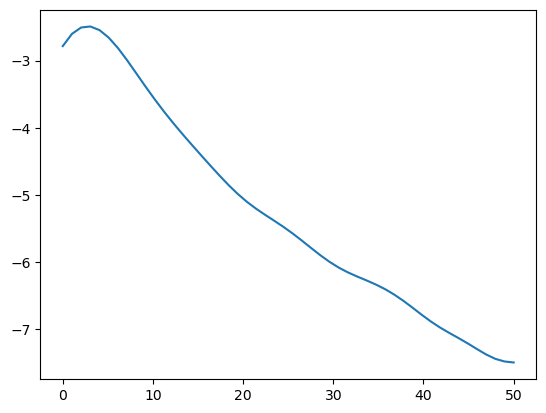

In [21]:
%matplotlib inline

from numpy import linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot

kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(deg.reshape(-1, 1))
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)


In [24]:
import numpy as np
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print ("Minima:", s[mi])
print ("Maxima:", s[ma])


Minima: []
Maxima: [3.06122449]


In [1]:


import torch
import gc
from utils.train_utils import build_model
from lighting_modules import TrainingPipeline
from utils.attack_utils import evaluate_attack

gc.collect()

20

In [89]:
node_pairs_num = []
for i in seq:
    tmp = torch.load(f'./outputs/node_pairs/lastfm/{i}')
    node_pairs_num.append(tmp["num_direct_connection"])
node_pairs_num

[1,
 4,
 12,
 7,
 4,
 1,
 12,
 6,
 11,
 8,
 7,
 1,
 20,
 9,
 8,
 1,
 10,
 3,
 1,
 5,
 9,
 1,
 1,
 1,
 3,
 1,
 5,
 1,
 7,
 4,
 17,
 3,
 10,
 2,
 1,
 1,
 20,
 1,
 2,
 1,
 10,
 1,
 1,
 2,
 6,
 9,
 2,
 2,
 3,
 1,
 9,
 1,
 6,
 2,
 2,
 3,
 20,
 1,
 1,
 2,
 20,
 1,
 6,
 2,
 2,
 10,
 1,
 8,
 12,
 1,
 1,
 12,
 10,
 2,
 20,
 3,
 13,
 6,
 20,
 3,
 1,
 4,
 1,
 3,
 3,
 20,
 2,
 20,
 3,
 2,
 2,
 5,
 16,
 1,
 1,
 17,
 1,
 6,
 20,
 3]

In [87]:
nodep = torch.load('./outputs/node_pairs/lastfm/5074')
nodep

FileNotFoundError: [Errno 2] No such file or directory: './outputs/node_pairs/lastfm/5074'

In [31]:
nodep

{'target_node': 194,
 'neighbor': [882,
  6372,
  18,
  194,
  421,
  454,
  478,
  615,
  630,
  642,
  643,
  1045,
  1079,
  1132,
  1144,
  1230,
  1384,
  1767,
  2335,
  2473,
  2535,
  2788,
  2830,
  2914,
  3163,
  3418,
  3445,
  3581,
  3596,
  3755,
  3762,
  3807,
  3820,
  3854,
  3887,
  3888,
  4042,
  4085,
  4093,
  4152,
  4212,
  4221,
  4319,
  4342,
  4419,
  4484,
  4693,
  4775,
  4811,
  4868],
 'num_direct_connection': 2}

In [22]:
res = torch.load('outputs/model_outputs/lastfm/GCN/100_simi_1_output.pt')

In [75]:
auc = torch.load('outputs/model_outputs/lastfm/sage/100_simi_1_auc.pt')

In [76]:
def evaluate_simi_attack(data_list):
    all_res = []
    for i in range(len(data_list[0])):
        cur = 0
        for j in range(len(data_list)):
            cur += data_list[j][i]
        all_res.append(cur / len(data_list))
    return all_res

evaluate_simi_attack(auc)

[0.7080490104816352,
 0.6835411238531947,
 0.7062214777386424,
 0.6904925418018173,
 0.6824902734679054,
 0.6822175839339463,
 0.681732827612135,
 0.6835411238531947]

In [174]:
n = 3
model_n = 'GAT'
res_3 = torch.load(f'outputs/model_outputs/lastfm/{model_n}/100_inf_{n}_output.pt')
auc_3 = torch.load(f'outputs/model_outputs/lastfm/{model_n}/100_inf_{n}_auc.pt')


In [175]:
processed_res = []
for i in range(len(res_3)):
    processed_res_tmp = []
    for p, a in res_3[i]:
        if p == 0:
            processed_res_tmp.append(0)
        else:
            processed_res_tmp.append(p / a)
    processed_res.append(processed_res_tmp)


In [154]:
processed_res = res_3

In [176]:
from sklearn.metrics import recall_score, precision_score
recalls = []
precisions = []
for i in range(100):
    cur_num = node_pairs_num[i]

    sorted_res = sorted(processed_res[i], reverse=True)
    k_th_largest = sorted_res[cur_num]
    y_pred = []
    for cur in processed_res[i]:
        if cur >= k_th_largest:
            y_pred.append(1)
        else:
            y_pred.append(0)
    if len(y_pred) < 50:
        y_pred = y_pred + [0] * (50 - len(y_pred))
    y_true = [1] * cur_num + [0] * (50 - cur_num)
    print(y_true)
    print(y_pred)
    recall = recall_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    print(recall)
    print(pre)
    recalls.append(recall)
    precisions.append(pre)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1.0
0.5
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1.0
0.8
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1.0
0.9230769230769231
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [177]:
sum(recalls)/100

0.9856554515745691

In [178]:
sum(precisions)/100

0.7205706989089335

In [48]:
tes_processed = []
for t, a in res_3[0]:
    if t != 0:
        tes_processed.append(t/a)
    else:
        tes_processed.append(0)
tes_processed

[0.294524759840017,
 0,
 0,
 0,
 0,
 1.0,
 0.0461701934254163,
 0,
 0.061350426076278095,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [28]:
res_3[99]

[(0.10275477170944214, 2.0973432064056396),
 (0.31440308690071106, 5.846919059753418),
 (0.018699772655963898, 0.13145029544830322),
 (0.0, 1.0429493188858032),
 (0.0, 0.293577641248703),
 (0.0, 5.25153112411499),
 (0.0, 0.9309921860694885),
 (0.0, 0.6288760304450989),
 (0.0006775913061574101, 1.2060781717300415),
 (0.0, 0.33423012495040894),
 (0.0, 1.78340744972229),
 (0.00013987801503390074, 0.155247300863266),
 (0.0, 0.1323278695344925),
 (0.0, 0.8957195281982422),
 (0.0, 3.5155107975006104),
 (0.0, 0.5870687365531921),
 (0.0, 4.441817283630371),
 (0.0, 0.5909842848777771),
 (0.0, 2.346834182739258),
 (0.0, 1.6582326889038086),
 (0.0, 2.8427159786224365),
 (0.0, 1.2886394262313843),
 (0.0, 0.2025946080684662),
 (0.0008742083446122706, 0.8733192086219788),
 (0.0, 0.3548920452594757),
 (0.0004797281580977142, 0.7942360043525696),
 (0.0, 3.8512773513793945),
 (0.0, 3.797970771789551),
 (0.0, 0.424045205116272),
 (0.0, 0.5530780553817749),
 (0.0, 1.9705281257629395),
 (0.0, 1.0176227092

In [34]:
model, datamodule, trainer = build_model('GCN', 'lastfm', ckpt='outputs/nlayer_4_hdim_256.pt', lr = 0.001, h_dim = 256, num_layers = 4,n_epoch = 300, dropout = 0.5, remove_self_loop = True)

# model, datamodule, trainer = build_model('GCN', 'twitch/DE', ckpt='./outputs/trained_model/GCN/twitch_de_4layer.pt', lr = 0.01, h_dim = 128, num_layers = 4,n_epoch = 200, dropout = 0.5, remove_self_loop = True)

pipeline = TrainingPipeline(model, datamodule, trainer)
#
# pipeline.run()
pipeline.test()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Dataset: LastFMAsia()
-------------------
Number of graphs: 1
Number of nodes: 7624
Number of features: 128
Number of classes: 18
setup


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    run/test_accuracy        90.81364440917969
      run/test_loss         0.35901328921318054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'run/test_accuracy': 90.81364440917969,
  'run/test_loss': 0.35901328921318054}]

In [35]:
graph_dataset = datamodule.full_attack_graph.clone()

In [36]:
from attacker import Attacker
attacker = Attacker(model, graph_dataset, 'lastfm')

In [37]:
target_nodes, node_pairs, num_direct_connections = attacker.load_node_pairs()

In [38]:
num_direct_connections

[4,
 9,
 10,
 1,
 20,
 1,
 1,
 1,
 20,
 1,
 2,
 8,
 4,
 3,
 7,
 1,
 2,
 1,
 5,
 1,
 6,
 20,
 3,
 20,
 1,
 2,
 3,
 11,
 2,
 3,
 12,
 16,
 3,
 20,
 12,
 6,
 1,
 9,
 2,
 1]

In [39]:
target_nodes

[1064,
 1326,
 1457,
 1473,
 1509,
 1513,
 1581,
 1596,
 1776,
 1797,
 194,
 1980,
 2063,
 2075,
 2108,
 2115,
 2168,
 2264,
 2271,
 2320,
 2413,
 2566,
 2649,
 2725,
 2764,
 278,
 2879,
 3079,
 3135,
 3183,
 3368,
 3497,
 3609,
 3653,
 3714,
 3777,
 3825,
 4259,
 4302,
 4486]

In [40]:
node_pairs[0]

[(1064, 958),
 (1064, 3666),
 (1064, 5646),
 (1064, 6415),
 (1064, 31),
 (1064, 53),
 (1064, 75),
 (1064, 80),
 (1064, 96),
 (1064, 98),
 (1064, 107),
 (1064, 110),
 (1064, 112),
 (1064, 122),
 (1064, 124),
 (1064, 140),
 (1064, 154),
 (1064, 160),
 (1064, 161),
 (1064, 174),
 (1064, 175),
 (1064, 188),
 (1064, 189),
 (1064, 221),
 (1064, 222),
 (1064, 232),
 (1064, 244),
 (1064, 260),
 (1064, 276),
 (1064, 277),
 (1064, 289),
 (1064, 299),
 (1064, 323),
 (1064, 340),
 (1064, 341),
 (1064, 373),
 (1064, 376),
 (1064, 392),
 (1064, 409),
 (1064, 421),
 (1064, 435),
 (1064, 447),
 (1064, 462),
 (1064, 464),
 (1064, 478),
 (1064, 483),
 (1064, 484),
 (1064, 491),
 (1064, 504),
 (1064, 520)]

In [44]:
all_ori = []
all_pos = []
influence_score_list, auc = attacker.attack("inf_3", 0)


auc = 1.0
ap = 0.8402782241912677


In [45]:
influence_score_list

[(0.18368880450725555, 0.3824763000011444),
 (0.34526193141937256, 0.715614378452301),
 (0.10192480683326721, 0.19831715524196625),
 (0.3460502326488495, 0.696160078048706),
 (0.0, 9.417840003967285),
 (0.0, 7.308379173278809),
 (0.0, 1.4883086681365967),
 (0.009298650547862053, 5.180327415466309),
 (0.0, 17.928274154663086),
 (0.0, 1.1733283996582031),
 (0.0, 6.002435207366943),
 (0.0, 0.10664278268814087),
 (0.0, 0.3230845332145691),
 (0.0, 0.7836201190948486),
 (0.0, 10.448690414428711),
 (0.004594104830175638, 0.9750965237617493),
 (0.0, 18.362289428710938),
 (0.03714944049715996, 13.219038009643555),
 (0.0, 0.9313156604766846),
 (0.0, 5.461695194244385),
 (0.015268770977854729, 4.309914588928223),
 (0.0, 8.232915878295898),
 (0.0, 18.16461181640625),
 (0.0, 0.35579147934913635),
 (0.0218182560056448, 2.29254150390625),
 (0.0, 0.8740295171737671),
 (0.0, 0.4893002510070801),
 (0.0, 0.6833919286727905),
 (0.0, 18.021137237548828),
 (0.0, 5.707077503204346),
 (0.0, 3.0618228912353516

In [ ]:
influence_score_list

In [13]:
from scipy.spatial.distance import cosine, euclidean


In [194]:
all_ori

[[tensor([[-2.8952e-04, -8.1475e+00],
          [-3.2869e-03, -5.7195e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8976e-04, -8.1467e+00],
          [-2.4614e-04, -8.3097e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8976e-04, -8.1466e+00],
          [-1.6991e-03, -6.3785e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8880e-04, -8.1499e+00],
          [-9.8567e-03, -4.6245e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8976e-04, -8.1467e+00],
          [-7.0202e-04, -7.2618e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8976e-04, -8.1466e+00],
          [-1.6391e-03, -6.4144e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8987e-04, -8.1464e+00],
          [-7.3894e-04, -7.2107e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8976e-04, -8.1467e+00],
          [-1.6647e-02, -4.1039e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.8892e-04, -8.1496e+00],
          [-1.5430e-03, -6.4748e+00]], grad_fn=<SliceBackward0>),
  tensor([[-2.9059e-04, -8.1437e+00],
          [-1.5723e-03, -6

In [17]:
cosine(post_output_list[0][1].detach().numpy(), post_output_list[0][2].detach().numpy())

1.1920928955078125e-07

In [57]:
all_ori[0][0][2]

tensor([-1.5854e-04, -8.7493e+00], grad_fn=<SelectBackward0>)

In [56]:
all_ori[0][0][1]

tensor([-3.2853e-03, -5.7199e+00], grad_fn=<SelectBackward0>)

In [ ]:
euclidean(all_ori[0][0][2])

In [75]:
i = 0
j  = 0
metrics = euclidean
all_simi = []
for i in range(50):
    ori_simi = metrics(all_ori[j][i][1].detach().numpy(), all_ori[j][i][2].detach().numpy())
    post_simi = metrics(all_pos[j][i][1].detach().numpy(), all_pos[j][i][2].detach().numpy())
    all_simi.append(abs(ori_simi - post_simi))


In [76]:
all_simi

[1.7881393432617188e-07,
 0,
 1.1920928955078125e-07,
 2.0265579223632812e-06,
 0,
 5.960464477539063e-08,
 1.1920928955078125e-07,
 8.106231689453125e-06,
 0,
 5.960464477539063e-08,
 0,
 5.960464477539063e-08,
 5.960464477539063e-08,
 0,
 0,
 0,
 0,
 4.172325134277344e-07,
 5.960464477539063e-08,
 0,
 0,
 0.0,
 1.1920928955078125e-07,
 0,
 0,
 0,
 0,
 5.364418029785156e-07,
 5.125999450683594e-06,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 0,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 1.1920928955078125e-07,
 1.1920928955078125e-07,
 5.960464477539063e-08,
 0.0,
 0,
 0.0003534555435180664,
 5.960464477539063e-08,
 5.960464477539063e-08,
 0,
 5.960464477539063e-08,
 5.960464477539063e-08,
 4.369020462036133e-05,
 0,
 0]

In [148]:
from sklearn import metrics

def eva(connected, unconnected):
    y = [1] * len(connected) + [0] * len(unconnected)
    pred = connected + unconnected

    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    auc = metrics.auc(fpr, tpr)
    auc = max(auc, 1 - auc)
    ap = metrics.average_precision_score(y, pred)

    print('auc =', auc)

    # get_auc(y, pred)
    # precision, recall, thresholds_2 = metrics.precision_recall_curve(y, pred)
    print('ap =', ap)
    return auc, ap


In [212]:
# for j in range(10):
import math
all_simi = []
ap_list = []
auc_list = []
metricsc = euclidean
for j in range(1):
    all_simi = []
    for i in range(50):
        ori_simi = metricsc(all_ori[j][i][0].detach().numpy(), all_ori[j][i][1].detach().numpy())
        post_simi = metricsc(all_pos[j][i][0].detach().numpy(), all_pos[j][i][1].detach().numpy())

        all_simi.append(ori_simi / post_simi)
        # all_simi.append((all_ori[j][i][0].detach() - all_pos[j][i][0].detach()).norm().item())
    # print(all_simi)
    auc, ap = eva(all_simi[:num_direct_connections[j]], all_simi[num_direct_connections[j]:])
    auc_list.append(auc)
    ap_list.append(ap)
print(sum(auc_list)/ len(auc_list))


C:\Users\szysz\AppData\Local\Temp\ipykernel_18836\3932286694.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  all_simi.append(ori_simi / post_simi)
C:\Users\szysz\AppData\Local\Temp\ipykernel_18836\3932286694.py:13: RuntimeWarning: invalid value encountered in scalar divide
  all_simi.append(ori_simi / post_simi)


ValueError: Input contains NaN.

In [208]:
ori_simi

1.1100274324417114

In [207]:
all_simi

[-0.03578591346740723,
 -3.5698304176330566,
 -0.6838358640670776,
 1.0987415313720703,
 -2.640013337135315,
 -0.8612825870513916,
 -2.168341279029846,
 2.432927131652832,
 -1.7460026741027832,
 -1.3145146369934082,
 -3.1464042365550995,
 0.005213499069213867,
 -1.2407305240631104,
 -2.314634919166565,
 -2.0103482007980347,
 -1.8494577407836914,
 -3.464953660964966,
 0.2948901653289795,
 -3.215924024581909,
 -1.3780707120895386,
 -1.8952871561050415,
 -1.4013193845748901,
 -0.33320140838623047,
 -2.998476505279541,
 -1.4740679264068604,
 -3.1769371032714844,
 -0.9289988279342651,
 0.4997434616088867,
 2.019270658493042,
 0.3241310119628906,
 -0.902764081954956,
 -2.8011605739593506,
 0.04910445213317871,
 -1.1809111833572388,
 -0.012126684188842773,
 -0.9491170644760132,
 -2.4274057149887085,
 1.0074281692504883,
 -0.6374368667602539,
 -0.38072967529296875,
 -1.2602808475494385,
 4.680414021015167,
 -2.636597603559494,
 -3.2212972342967987,
 -0.820927619934082,
 -2.9501068592071533,
 -

In [198]:
torch.save(all_pos, 'outputs/model_outputs/twith/de/simi_attack4/all_pos.pt')

In [141]:
target = 8

o = metricsc(all_ori[0][target][1].detach().numpy(), all_ori[0][target][2].detach().numpy())
p = metricsc(all_pos[0][target][1].detach().numpy(), all_pos[0][target][2].detach().numpy())
print(o)
print(p)
print(abs(o - p))

0
0
0


In [181]:
sum(auc_list)/ len(auc_list)

0.6446531403258977

In [182]:
sum(ap_list)/ len(ap_list)

0.3614902996427644

In [40]:
all_simi

[3.772221565246582,
 5.1728620529174805,
 4.1683549880981445,
 2.9990673065185547,
 5.0388641357421875,
 4.298795700073242,
 4.77536678314209,
 3.214529037475586,
 4.133251190185547,
 3.2185230255126953,
 4.880217552185059,
 4.116890907287598,
 4.569755554199219,
 4.4509735107421875,
 4.61534309387207,
 5.621400833129883,
 4.727590560913086,
 3.97011661529541,
 5.02764892578125,
 4.618775367736816,
 4.2874555587768555,
 3.914182662963867,
 5.107090950012207,
 5.483379364013672,
 3.88700008392334,
 4.48233699798584,
 2.511455535888672,
 3.344165802001953,
 2.093902587890625,
 2.942856788635254]

In [45]:
evaluate_attack(all_simi[:20], all_simi[20:])

auc = 0.6
ap = 0.5263157894736842


(0.6, 0.5263157894736842)

In [12]:
post_output_list[0]

tensor([[-6.1989e-06, -1.1984e+01],
        [-8.7022e-06, -1.1653e+01],
        [-2.8976e-04, -8.1466e+00]], grad_fn=<SliceBackward0>)

In [ ]:
post_output_list[0]

In [9]:
inflist = []
for i in range(5):
    print(f'--------------------------------------attack_{i}')
    inflist.append(attacker.attack("inf_2", i))

--------------------------------------attack_0


C:\Users\szysz\anaconda3\envs\link_re-identification_attack\lib\site-packages\scipy\spatial\distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


auc = 0.7008333333333333
ap = 0.7366279069767443
auc = 0.625
ap = 0.6


ValueError: Input contains NaN.

In [ ]:
ori_output_list

In [9]:
inflist

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.223388671875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
from utils.attack_utils import get_similarity, evaluate_attack
simi_o = []
simi_p = []
for i in range(50):
    simi_o.append(get_similarity(ori_output_list[i][1].detach().numpy(), ori_output_list[i][2].detach().numpy()))
    simi_p.append(get_similarity(post_output_list[i][1].detach().numpy(), post_output_list[i][2].detach().numpy()))

In [ ]:
post_output_list[9]

In [ ]:
simi_o

In [ ]:
simi_o

In [ ]:
simi_p

In [ ]:
# for tar in range(8):
tar = 1
stat = []
for i in range(50):
    print(f'{simi_o[i][tar]} ------ {simi_p[i][tar]}')
    stat.append(simi_o[i][tar] - simi_p[i][tar])

print(evaluate_attack(stat[:20], stat[20:]))


In [ ]:
for tar in range(8):
    stat = []
    for i in range(50):
        stat.append(simi_o[i][tar] - simi_p[i][tar])
    print(evaluate_attack(stat[:20], stat[20:]))


In [ ]:
evaluate_attack(stat[:20], stat[20:])

In [ ]:
evaluate_attack(stat[:20], stat[20:])

In [2]:
from utils.node_pair_sampling_utils import NodePairsSampler
twitch_sampler = NodePairsSampler(graph_dataset, 'twitch/de', root_path='./outputs')
twitch_sampler.construct_centroid_pairs_set(10)

NameError: name 'graph_dataset' is not defined

In [ ]:
from utils.node_pair_sampling_utils import read_node_pairs
centroid_node_list, formatted_node_pairs, num_connected_nodes = read_node_pairs('twitch/de')

In [ ]:
norm_0 = []
norm_1 = []
norm_s = []
for i in range(50):
    n0 = (before_out[i][0] - post_out[i][0]).norm()
    n1 = (before_out[i][1] - post_out[i][1]).norm()
    norm_0.append(n0.item())
    norm_1.append(n1.item())
    norm_s.append((n0 + n1).item())

print(norm_0)
print(norm_1)
print(norm_s)



In [43]:
from utils.graph_utils import add_new_node_to_graph,remove_target_node
from utils.attack_utils import evaluate_attack
def influence_attack_1(node_pairs, num_connected):
    influence_score_list = []
    for i in range(len(node_pairs)):
        influence_score_list.append(influence_attack_1_process(node_pairs[i][0], node_pairs[i][1]))
    evaluate_attack(influence_score_list[:num_connected], influence_score_list[num_connected:])
    return influence_score_list

def influence_attack_1_process(target_node_1, target_node_2, insert_node_attribute=0, influence_rate=0.0001):
    # insert 2 node connected to node 1
    add_new_node_to_graph(graph_dataset, graph_dataset.x[insert_node_attribute], target_node_1,
                          y=graph_dataset.y[insert_node_attribute])
    add_new_node_to_graph(graph_dataset, graph_dataset.x[insert_node_attribute], target_node_2,
                          y=graph_dataset.y[insert_node_attribute])

    # perturbation to the node feature
    insert_node_1_ind = graph_dataset.x.shape[0] - 2
    insert_node_2_ind = graph_dataset.x.shape[0] - 1

    influence_matrix = get_influence_score(insert_node_1_ind, influence_rate)

    # delete inserted nodes
    remove_target_node(graph_dataset, graph_dataset.x.shape[0] - 1)
    remove_target_node(graph_dataset, graph_dataset.x.shape[0] - 1)

    # get the influence of target node on all other nodes
    influence_score = influence_matrix[insert_node_2_ind].norm().item()
    return influence_score

def get_influence_score(target_node, influence=0.01):
    pert = torch.zeros_like(graph_dataset.x)
    pert[target_node] = graph_dataset.x[target_node] * influence
    ori_output = model.predict_step(graph_dataset, 0)

    original_feature = graph_dataset.x.clone()

    # perturb the node feature
    graph_dataset.x = original_feature + pert
    pert_output = model.predict_step(graph_dataset, 0)
    graph_dataset.x = original_feature

    grad = (pert_output.detach() - ori_output.detach()) / influence
    return grad


In [8]:
node_pair = torch.load('outputs/node_pairs/twitch/de/8365')

In [9]:
node_pair

{'target_node': 8365,
 'neighbor': [299,
  343,
  721,
  1173,
  1276,
  1320,
  1387,
  1638,
  2293,
  2452,
  2684,
  2816,
  2825,
  3126,
  3677,
  4004,
  4038,
  4139,
  4927,
  5160,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 'num_direct_connection': 20}

In [28]:
from torch_geometric.utils import k_hop_subgraph

neighbors, _, _, _ = k_hop_subgraph(8365, 2, graph_dataset.edge_index, relabel_nodes=False)


In [31]:
neighbors

tensor([   0,    1,    2,  ..., 9495, 9496, 9497])

In [37]:
node_pair['neighbor'][0]

299

In [38]:

influence_score_list = []
for i in node_pair['neighbor']:
    influence_score_list.append(influence_attack_1_process(8365, i, 0, 0.1))
influence_score_list

[0.522308349609375,
 0.00019315080135129392,
 0.00021458980336319655,
 0.00015259251813404262,
 0.00013830284297000617,
 0.0009012253722175956,
 0.7671356201171875,
 3.337860107421875e-05,
 0.001712636323645711,
 0.0001239776611328125,
 2.86102294921875e-05,
 3.814697265625e-05,
 0.002358900150284171,
 0.000505459844134748,
 0.006603327114135027,
 0.0001716654805932194,
 4.535648986347951e-05,
 5.7220458984375e-05,
 2.86102294921875e-05,
 0.000782012939453125,
 0.0,
 4.76837158203125e-05,
 0.0,
 9.5367431640625e-06,
 7.62939453125e-05,
 1.9073486328125e-05,
 0.0,
 9.5367431640625e-06,
 0.0,
 0.0,
 9.5367431640625e-06,
 0.0,
 0.0,
 0.0,
 2.86102294921875e-05,
 8.113473450066522e-05,
 5.9604644775390625e-06,
 3.814697265625e-05,
 0.0,
 0.0,
 9.5367431640625e-06,
 9.610384040570352e-06,
 4.291534423828125e-05,
 9.5367431640625e-06,
 0.00011444091796875,
 1.9073486328125e-05,
 0.0,
 7.152557373046875e-06,
 0.0,
 0.0]

In [44]:
evaluate_attack(influence_score_list[:20], influence_score_list[20:])

auc = 0.9475
ap = 0.4379223889510039


(0.9475, 0.4379223889510039)

In [7]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_test = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
y_probs = [1, 0.9, 0.8, 0.85, 0, 0, 0.2, 0.3, 0, 0]
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9523809523809523
